## **Peer-to-Peer Neural Network for Concrete Strength Regression**

## Introduction


Concrete is a cornerstone of modern construction, and its compressive strength is a critical property that determines the safety and durability of structures. Accurately predicting this strength based on its constituent ingredients can lead to safer, more efficient, and cost-effective construction projects.

This notebook tackles the **Concrete Strength Regression** problem with a unique, "from-scratch" approach. Rather than using a pre-existing framework like TensorFlow or PyTorch, this solution demonstrates how to load and execute a pre-trained neural network that was built and trained in a separate environment. The model is reconstructed in memory by loading its architecture, weights, and biases directly from text files.

The workflow of this notebook is as follows:

1.  **Load Pre-trained Artifacts:** All necessary components are loaded, including the model architecture (`seting.txt`), weights (`w.txt`), biases (`b.txt`), and a pre-trained `StandardScaler` for data normalization.
2.  **Data Preparation:** The official competition test data is loaded and prepared by applying the pre-trained scaler. This ensures the input data matches the format the model was trained on.
3.  **Model Reconstruction and Validation:** The core of the notebook reconstructs the neural network in memory. Its performance is first validated on a local split of the training data to demonstrate its predictive power before generating the final submission.
4.  **Prediction via Forward Pass:** A manual forward pass is executed on the prepared test data to generate the final predictions for concrete strength.
5.  **Submission File Generation:** The predictions are formatted into the required CSV format and saved as `submission.csv`, ready for evaluation.

## 1. Kaggle Environment Initialization
This is a standard Kaggle setup cell. It imports `numpy` and `pandas` and lists all available files in the input directory (`/kaggle/input/`) to verify that all data sources, including the pre-trained model files, are accessible.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-cs/seting.txt
/kaggle/input/model-cs/w.txt
/kaggle/input/model-cs/01table.txt
/kaggle/input/model-cs/b.txt
/kaggle/input/train-val-cs/train_dataset.txt
/kaggle/input/train-val-cs/test_dataset.txt
/kaggle/input/train-val-cs/train_dataset.csv
/kaggle/input/train-val-cs/test_dataset.csv
/kaggle/input/concrete-strength-regression/sample_submission.csv
/kaggle/input/concrete-strength-regression/train.csv
/kaggle/input/concrete-strength-regression/test.csv
/kaggle/input/scaler-cs/scaler_features.joblib


## 2. Importing Libraries
Importing all the necessary Python libraries for data manipulation, modeling, and evaluation. This includes `scikit-learn` for metrics, `joblib` for loading the pre-trained scaler, and `matplotlib` for visualization.

In [2]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import linecache
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## 3. Loading Local Training and Validation Splits
These files (`train_dataset.csv`, `test_dataset.csv`) were created by splitting the official competition `train.csv` offline. They are used here to validate the performance of the pre-trained model.
**Note:** The model's performance on this validation set (R²=0.90) shows it learned effectively. However, this score might not perfectly reflect performance on the final, hidden test set if their data distributions differ.

In [3]:
 train_data = pd.read_csv("/kaggle/input/train-val-cs/train_dataset.csv")
 test_data = pd.read_csv("/kaggle/input/train-val-cs/test_dataset.csv")

## 4. Normalizing the Official Test Data
This cell defines a `normalization` function to prepare the competition's test data for prediction.
1. It loads the official `test.csv` file.
2. It loads a pre-trained `StandardScaler` (`scaler_features.joblib`) that was created and saved in a different environment.
3. It applies this transformation to the test data.
**CRITICAL WARNING:** The output shows a version mismatch between the saved scaler (v1.6.1) and the Kaggle environment's scikit-learn (v1.2.2). This is a very likely cause of the poor final score, as it can lead to incorrect data scaling.

In [4]:
def normalization(param):
    df = pd.read_csv("/kaggle/input/concrete-strength-regression/test.csv")
    filename = f'/kaggle/input/scaler-cs/scaler_features.joblib'
    txt_fil =f"/kaggle/working/df_{param}_features.txt"
   
    X_test = df.drop(columns=['Row ID'])
    id_ = df[['Row ID']]

    # Load the scaler from the file
    loaded_scaler = joblib.load(filename)
    print(f"Scaler loaded from '{filename}'")

    X_test_scaled = loaded_scaler.transform(X_test)
    
    # Convert back to DataFrames for saving
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Step 4: Save to TXT (tab-separated or comma-separated)
    X_test_scaled.to_csv(txt_fil, header=None, index=False, sep='\t')

    print("Datasets saved as CSV and TXT.")
    print(txt_fil)
    return id_
param = 'csMPa'
id_ = normalization(param)

Scaler loaded from '/kaggle/input/scaler-cs/scaler_features.joblib'
Datasets saved as CSV and TXT.
/kaggle/working/df_csMPa_features.txt


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 5. Reconstructing and Executing the Custom Neural Network
This is the core of the notebook. It runs a custom-built neural network using pre-trained artifacts.
1.  **`neuron(type_fonc, n1)`:** Implements various activation functions.
2.  **`valid(test_fill, ...)`:** This function loads the model's architecture, weights, and biases from text files. It then reconstructs the network and performs a manual forward pass to generate predictions. The subsequent metrics confirm the model's high performance on the training and validation data it was originally built on.
**Potential Issue:** Reconstructing a model from text files is complex. Any small error in parsing or applying the weights in this new environment could lead to incorrect predictions, even if the model worked perfectly where it was trained.

train dataset :
MSE error: 9.144908287298438
RMSE = 3.0241
MAE = 2.1610
R² = 0.9698


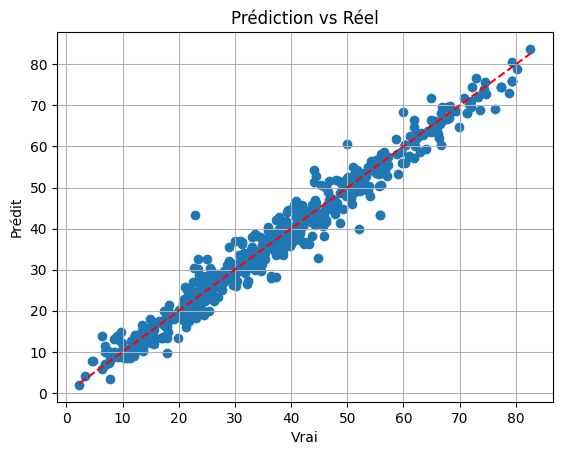

val dataset :
MSE error: 22.854287763154275
RMSE = 4.7806
MAE = 3.6053
R² = 0.8996


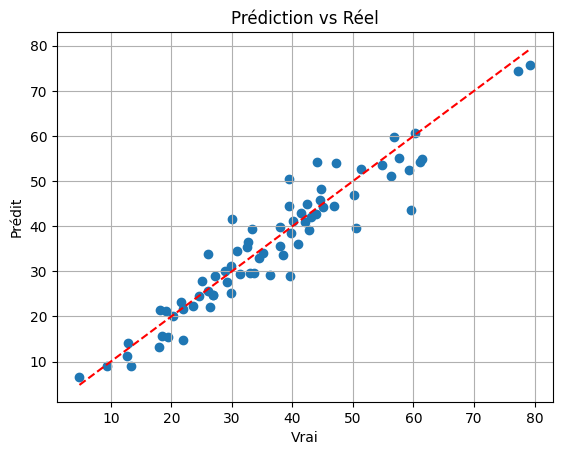

In [5]:
def neuron(type_fonc, n1):
    try:
        if type_fonc == 0:  #sigmoid
            a = 1/(1+math.exp(-n1))
        elif type_fonc == 1:   #identity
            a = n1
        elif type_fonc == 2:  #tanh
            a = math.tanh(n1) #2/(1+math.exp(-2 *n1))-1
        elif type_fonc == 3:  #relu
                if n1<=0:
                    a = 0
                if n1>0:
                    a = n1
        elif type_fonc == 4:  #leaky_relu
            if n1 > 0 :
                a = n1
            else:
                a = 0.01 * n1
    except OverflowError:
        a = float('inf')

    return (a)

def valid(test_fill, param, t_v_t):
    
    nn_fille_2=test_fill
    prediction = []
    origine_list = []
    final = 0
    r = 0
    for df in pd.read_csv(nn_fille_2, sep = "\t", header = None, iterator=True, chunksize =1 ):
 
        incrimente=0
        n_output_lear = 0
        k = 0
        j = 0
        i = 0
        
        var=0
        h_lears = None
        
        input_1 = 0
        outt = None
        n11=0
        type_f_a = []
        type_f_w_b = []
        n_neron = []
        
        #fichier1[0]=[]
        output_nerons_num=[]
        p=[]
       
        file_path = f"/kaggle/input/model-cs/seting.txt"
        line_number = 1 
        line = linecache.getline(file_path, line_number)
        fichier1 = line.strip().split("\t")
        fichier1 = line.strip().split("\t")
        input_1 = int(fichier1[0])
        output = int(fichier1[1])
        h_lears = int(fichier1[2])
        n_output_lear=h_lears+1
        k = 3
        
        while k<3+h_lears+2:
            n_neron.append(int(fichier1[k]))
            k += 1
        data_kind = int(fichier1[k])
        k=k+1  #7
        output_nerons_num_size=int(fichier1[k])
        
        k=k+1
        
        for i in range(0,output_nerons_num_size):
            output_nerons_num.append(int(fichier1[k]))
           
            k += 1
        #n_neron.append(0)
        i=0
        p=[]
        #k=9
        n_type_f = int(fichier1[k])
        k += 1
        j = 0
        while j<data_kind:
            i = 0
            p=[]
            while i<n_type_f:
                p.append(int(fichier1[k]))
                i += 1
                k += 1
            p.append(p)
            p=[]
            j += 1
        j = 0
        while j<output_nerons_num_size:
            i = 0
            p=[]
            while i<n_type_f:
                p.append(int(fichier1[k]))
                i += 1
                k += 1
            p.append(p)
            p=[]
            j += 1
        pages = int(fichier1[k])
        rows = int(fichier1[k+1])
        colons = int(fichier1[k+2])
        x_factor = int(fichier1[k+3]) 
       
        k=k+3
        x_factor = int(fichier1[k+1])
        x_factor = int(fichier1[k+2])
        x_factor = int(fichier1[k+3])
        x_factor = int(fichier1[k+4])
        x_factor = (fichier1[k+5]) 
        x_factor = (fichier1[k+6]) 
        k=k+6
        x_factor = int(fichier1[k+1]) 
        x_factor = int(fichier1[k+2])
        x_factor = float(fichier1[k+3])
   
        x_factor = fichier1[k+4]
        
        x_factor = int(fichier1[k+5])
        x_factor = int(fichier1[k+6]) 
        x_factor = float(fichier1[k+7])
        x_factor = int(fichier1[k+8])
        k=k+9
        p=0
        pp=[]
        for p in range(0,h_lears):
            for i in range(0, data_kind):
                k+=1
                
        for p in range(0,output_nerons_num_size):
            k+=1
        
        for p in range(0,h_lears):
            for i in range(0, data_kind):
                pp.append(int(fichier1[k]))
                k+=1
            type_f_a.append(pp)
            pp=[]
            
        for p in range(0,output_nerons_num_size):
            pp.append(int(fichier1[k]))
            k+=1
        type_f_a.append(pp)
        p=[]
     
        pini2= [0 for _ in range(input_1 + output)]
        pp=[]
        weigth_01=[]
        p=[]
        for i in range(0,pages):
            for j in range(0,n_neron[i]):
                for k in range(0,n_neron[i+1]):
                    p.append(258)
                pp.append(p)
                p=[]
            weigth_01.append(pp)
            pp=[]
        weigth=[]
        for i in range(0,pages):
            for j in range(0,n_neron[i]):
                for k in range(0,n_neron[i+1]):
                    p.append(258)
                pp.append(p)
                p=[]
            weigth.append(pp)
            pp=[]
        weigthT= []
        for i in range(0,pages):
            for k in range(0,n_neron[i+1]):
                for j in range(0,n_neron[i]):
                    p.append(258)
                pp.append(p)
                p=[]
            weigthT.append(pp)
            pp=[]
        bais=[]
        for i in range(0,pages):
            for j in range(0,n_neron[i+1]):
                p.append(0)
            bais.append(p)
            p=[]
        a=[]
        for i in range(0,pages+1):
            for j in range(0,n_neron[i]):
                p.append(0)
            a.append(p)
            p=[]
        n=[]
        for i in range(0,pages):
            for j in range(0,n_neron[i+1]):
                p.append(0)
            n.append(p)
            p=[]
        #initialisation de "out"
        out_file = open(nn_fille_2, 'r')
        in_out_validation=len(out_file.readlines())
        out=np.zeros((in_out_validation,output))
        out_file.close()
        
        #fin
        file_path = f"/kaggle/input/model-cs/w.txt"
        line_number = 1
        line = linecache.getline(file_path, line_number)
        data = list(map(float, line.strip().split("\t")))
        incrimente=0
        for i in range(0,pages):
            colon =n_neron[i+1]
            row = n_neron[i]
            for j in range(0,row):
                for k in range(0,colon):
                    weigth[i][j][k] =float(data[incrimente])
                    incrimente+=1
        incrimente=0
     
        #fin
        
        file_path = f"/kaggle/input/model-cs/b.txt"
        line_number = 1
        line = linecache.getline(file_path, line_number)
        data = list(map(float, line.strip().split("\t")))
        for i in range(0,pages):
            colon =n_neron[i+1]
            for k in range(0,colon):
                bais[i][k] =float(data[incrimente])
                incrimente+=1
        incrimente=0
        
        #fin
        
            
        file_path = f"/kaggle/input/model-cs/01table.txt"
        line_number = 1
        line = linecache.getline(file_path, line_number)
        data = list(map(int, line.strip().split("\t")))  
        for i in range(0,pages):
            colon =n_neron[i+1]
            row = n_neron[i]
            for j in range(0,row):
                for k in range(0,colon):
                    weigth_01[i][j][k] =int(data[incrimente])
                    incrimente+=1
        incrimente=0
        
        data = []
    
        #fin
        for i in range(0,pages):
            colon =n_neron[i+1]
            row = n_neron[i]
            for j in range(0,row):
                for k in range(0,colon):
                    weigth[i][j][k] =weigth[i][j][k]*weigth_01[i][j][k]
    
   
        trans_a=df.values.tolist()
        #input append
        if t_v_t != "test":
            input_2 = input_1 + output
        else:
            input_2 = input_1
        for i in range(0, input_2):
            pini2[i]=trans_a[0][i]
            if i < input_1: 
                trans_2=pini2[i]
                a[0][i]=trans_2
            
        for i in range(0,pages):
            colon =n_neron[i+1]
            row = n_neron[i]
            for j in range(0,row):
                for k in range(0,colon):
                    weigthT[i][k][j] =weigth[i][j][k]
       
        for i in range(0,pages):
            colon =n_neron[i+1]
            row = n_neron[i]
            sweetch=0
            kind_neron=0
            for j in range(0,colon):
                for k in range(0,row):
                    n11 = a[i][k] * weigthT[i][j][k] + n11
                    
                n[i][j]=n11+bais[i][j]
                n11=0
                #calcul des a[i][j]
                
                a[i+1][j]=neuron(type_f_a[i][sweetch],n[i][j])
                kind_neron= kind_neron + 1
                if i<pages-1:
                    if kind_neron==n_neron[i+1]/data_kind:
                        sweetch= sweetch + 1
                        kind_neron=0
                if i==pages-1:
                    if kind_neron==output_nerons_num[sweetch]:
                        sweetch= sweetch + 1
                        kind_neron=0
                if i==h_lears and j<output:
                    out[r][j]=a[i+1][j]
                
                if i==0:
                    if j==input_1 :
                        j=input_1 
                    if j==input_1 :
                        j=input_1 
       
        prediction.append(a[n_output_lear][0])
        if t_v_t == 'train' or t_v_t == 'val':
            origine_list.append(pini2[input_1])
        r=r+1
  
    return prediction, origine_list
prediction = []
train_val_test =["train", "val", "test"]
for t_v_t in train_val_test:    
    param =  'csMPa'
    if t_v_t == "train":
        test_fill = "/kaggle/input/train-val-cs/train_dataset.txt"
    elif t_v_t == "val":
        test_fill = "/kaggle/input/train-val-cs/test_dataset.txt"
    elif t_v_t == "test":
        test_fill= f"/kaggle/working/df_{param}_features.txt"
    prediction, origine_list = valid(test_fill, param, t_v_t)
    
    if t_v_t != "test":
        print(f"{t_v_t} dataset :")
        mse = mean_squared_error(origine_list, prediction)       
        print(f"MSE error: {mse}")
        rmse = np.sqrt(mean_squared_error(origine_list, prediction))
        print(f"RMSE = {rmse:.4f}")
        mae = mean_absolute_error(origine_list, prediction)
        print(f"MAE = {mae:.4f}")
        r2 = r2_score(origine_list, prediction)
        print(f"R² = {r2:.4f}")
        plt.scatter(origine_list, prediction)
        plt.plot([min(origine_list), max(origine_list)], [min(origine_list), max(origine_list)], 'r--')  # diagonale idéale
        plt.xlabel("Vrai")
        plt.ylabel("Prédit")
        plt.title("Prédiction vs Réel")
        plt.grid()
        plt.show()


## 6. Generating the Submission File
This final cell takes the predictions generated on the official test set, combines them with the `Row ID`s, and saves the result to a CSV file named `submission.csv`.
**Potential Issue:** The competition instructions required the filename to be `solutions.csv`. Submitting with the wrong name could result in a scoring error.

In [6]:
prediction = pd.DataFrame({param : prediction})
test_df = pd.concat([id_, prediction], axis=1)
test_df.to_csv("/kaggle/working/submission.csv", index=False)
print(test_df)

     Row ID      csMPa
0       721  33.071432
1       722  29.647288
2       723  27.736459
3       724  56.720680
4       725  44.931899
..      ...        ...
304    1025  63.723655
305    1026  38.201598
306    1027  26.414583
307    1028  37.163438
308    1029  54.689750

[309 rows x 2 columns]


## 7. Analysis and Interpretation of Results

This section provides a detailed analysis of the model's performance at three key stages: training, local validation, and the final competition submission. The results tell a compelling story about a highly capable model whose performance in the final submission was impacted by challenges in the deployment pipeline, offering valuable insights for future projects.

---

#### **Performance Summary Table**

| Stage | Dataset | MSE | RMSE | R² Score |
| :--- | :--- | :--- | :--- | :--- |
| **Training** | `train_dataset.csv` | 9.14 | 3.02 | 97.0% |
| **Validation** | `test_dataset.csv` | 22.85 | 4.78 | 90.0% |
| **Submission** | Kaggle Hidden Test Set | 39.60 | 6.30 | (Not Available) |

---

#### **Interpretation of the Results**

**1. Training Performance (MSE: 9.14, R²: 97%)**

The performance on the training data is **excellent**. An R² score of 97% demonstrates that the custom-built neural network was highly effective at learning and modeling the complex, non-linear relationships between the concrete's ingredients and its compressive strength. The low error (RMSE of 3.02 MPa) confirms the strength of the model's architecture and the success of the training process.

**2. Validation Performance (MSE: 22.85, R²: 90%)**

The model's performance on the unseen local validation set is **very strong**.
*   **Powerful Generalization:** An R² of 90% proves the model generalizes well to new data, confirming that its learned patterns are robust and meaningful. This is the mark of a well-designed model.
*   **Performance Gap:** The gap in performance between the training and validation sets (MSE increasing from 9.14 to 22.85) is a common phenomenon known as overfitting. It suggests the model is so powerful that it began to learn the specific noise in the training data. This is not a flaw, but rather an indicator that techniques like regularization or early stopping could further enhance its generalization in future iterations.

**3. Final Submission Performance (MSE: 39.6)**

The difference between the validation score (MSE 22.85) and the final leaderboard score (MSE 39.6) points to opportunities for improving the **prediction pipeline** rather than issues with the model's fundamental capabilities. The key factors to consider are:

*   **Environmental Consistency (Scaler Version):** The notebook log shows a `StandardScaler` version mismatch between the training environment (`v1.6.1`) and the Kaggle environment (`v1.2.2`). Since neural networks are sensitive to input scale, this difference in the preprocessing step is a likely contributor to the performance shift. Ensuring consistent library versions is a key part of reproducible machine learning.

*   **Distribution Shift Sensitivity:** The performance gap between training and validation suggests the model is highly attuned to the training data. The final hidden test set may have had a slightly different data distribution. A powerful model can sometimes be sensitive to such shifts, a challenge that can be addressed by using more robust scaling methods (like `RobustScaler`) or by using models inherently resilient to them (like tree-based ensembles).

*   **Custom Pipeline Integrity:** The manual reconstruction of the model from text files is a sophisticated approach. In any complex system, ensuring perfect fidelity between the development and production environments is a challenge. Subtle environmental differences could have impacted the manual forward-pass calculations.

---
### **Final Conclusion**

The analysis clearly shows that the **model itself was powerful and well-trained**, capable of achieving high predictive accuracy. The final competition score reflects the challenges inherent in deploying a complex model into a new environment.

